<a href="https://colab.research.google.com/github/hillasch/SPICE-model/blob/submission/DataPrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import subprocess
import hashlib
from glob import glob
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# -----------------------------
# Config
# -----------------------------
REPO_URL = "https://github.com/simran-khanuja/image-transcreation.git"
REPO_DIR = "image-transcreation-repo"
OUTPUT_CSV = "dataset_cap_edit_only.csv"

FINAL_COLS = [
    "unique_id", "filename", "src_url", "target_country", "src_country",
    "caption", "llm_edit", "comp_url", "src_local_path", "comp_local_path"
]

# -----------------------------
# Helpers
# -----------------------------
def download_repo():
    if not os.path.exists(REPO_DIR):
        print(f"--- Cloning repository from {REPO_URL} ---")
        subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)
        print("--- Repository cloned successfully ---")
    else:
        print(f"--- Repository already exists in {REPO_DIR} ---")

def sha1_16(s: str) -> str:
    return hashlib.sha1(s.encode("utf-8")).hexdigest()[:16]

def norm_path(p):
    if p is None or pd.isna(p):
        return None
    return str(p).replace("\\", "/").strip()

def normalize_meta_columns(df_meta: pd.DataFrame, meta_file: str) -> pd.DataFrame:
    # src_image_path
    if "src_image_path" not in df_meta.columns:
        for cand in ["src_path", "source_path", "image_path"]:
            if cand in df_meta.columns:
                df_meta = df_meta.rename(columns={cand: "src_image_path"})
                break

    # caption
    if "caption" not in df_meta.columns:
        for cand in ["src_caption", "source_caption", "blip_caption", "raw_caption"]:
            if cand in df_meta.columns:
                df_meta = df_meta.rename(columns={cand: "caption"})
                break

    # llm_edit
    if "llm_edit" not in df_meta.columns:
        for cand in ["LLM_edit", "edited_caption", "gpt_edit", "edit"]:
            if cand in df_meta.columns:
                df_meta = df_meta.rename(columns={cand: "llm_edit"})
                break

    need = ["src_image_path", "src_country", "llm_edit"]
    miss = [c for c in need if c not in df_meta.columns]
    if miss:
        raise ValueError(f"metadata missing {miss} in {meta_file}. cols={df_meta.columns.tolist()}")

    df_meta["src_image_path"] = df_meta["src_image_path"].apply(norm_path)
    return df_meta

def normalize_split_columns(df: pd.DataFrame, split_file: str) -> pd.DataFrame:
    """
    We require these columns:
      src_image_path
      model_1, model_2, model_3
      model_path_1, model_path_2, model_path_3
    """
    if "src_image_path" not in df.columns:
        for cand in ["src_path", "source_path", "image_path"]:
            if cand in df.columns:
                df = df.rename(columns={cand: "src_image_path"})
                break

    needed = ["src_image_path",
              "model_1", "model_2", "model_3",
              "model_path_1", "model_path_2", "model_path_3"]
    miss = [c for c in needed if c not in df.columns]
    if miss:
        raise ValueError(f"Split missing {miss}: {split_file}. cols={df.columns.tolist()}")

    df = df[needed].copy()

    df["src_image_path"] = df["src_image_path"].apply(norm_path)
    for c in ["model_path_1", "model_path_2", "model_path_3"]:
        df[c] = df[c].apply(norm_path)
    for c in ["model_1", "model_2", "model_3"]:
        df[c] = df[c].astype(str).str.strip().str.lower()

    return df

def pick_cap_edit_path(row) -> str | None:
    """
    Return the model_path_k where model_k == 'cap-edit'.
    If none -> None.
    """
    for k in (1, 2, 3):
        if row.get(f"model_{k}") == "cap-edit":
            return row.get(f"model_path_{k}")
    return None

# -----------------------------
# Main build
# -----------------------------
def build_dataset():
    download_repo()

    all_rows = []
    parts = ["part1", "part2"]

    print("--- Starting Data Processing ---")

    for part in parts:
        metadata_base_path = os.path.join(REPO_DIR, "outputs", part, "caption-llm_edit")
        outputs_base_path  = os.path.join(REPO_DIR, "outputs", part, "all_images")

        if not os.path.exists(metadata_base_path):
            print(f"Warning: Path not found {metadata_base_path}")
            continue

        target_countries = [
            d for d in os.listdir(metadata_base_path)
            if os.path.isdir(os.path.join(metadata_base_path, d))
        ]

        for target_country in target_countries:
            # 1) metadata.csv
            meta_file = os.path.join(metadata_base_path, target_country, "metadata.csv")
            if not os.path.exists(meta_file):
                continue

            df_meta = pd.read_csv(meta_file)
            df_meta = normalize_meta_columns(df_meta, meta_file)

            df_meta["dataset_part"] = part
            df_meta["target_country"] = target_country

            # 2) splits
            split_files = glob(os.path.join(outputs_base_path, target_country, "split_*.csv"))
            if not split_files:
                print(f"Warning: No split files found for {target_country} in {part}")
                continue

            splits = []
            for fp in split_files:
                d = pd.read_csv(fp)
                d = normalize_split_columns(d, fp)
                d["dataset_part"] = part
                d["target_country"] = target_country
                splits.append(d)

            df_splits = pd.concat(splits, ignore_index=True)

            # 3) merge on src_image_path (+ part + target_country)
            merged = pd.merge(
                df_meta,
                df_splits,
                on=["src_image_path", "dataset_part", "target_country"],
                how="inner"
            )

            # 4) choose cap-edit path
            merged["comp_url"] = merged.apply(pick_cap_edit_path, axis=1)
            merged = merged[merged["comp_url"].notna()].copy()  # keep only cap-edit rows

            # 5) filename + schema mapping
            merged["filename"] = merged["src_image_path"].apply(lambda p: os.path.basename(p) if p else None)
            merged["src_url"] = merged["src_image_path"]  # SOURCE image

            # local_path columns: you don't have actual local files -> keep URL for convenience
            merged["src_local_path"] = merged["src_url"]
            merged["comp_local_path"] = merged["comp_url"]

            # 6) unique_id
            merged["unique_id"] = merged.apply(
                lambda r: sha1_16(
                    f"{r.get('dataset_part','')}||{r.get('target_country','')}||"
                    f"{r.get('src_url','')}||{r.get('comp_url','')}||{r.get('filename','')}"
                ),
                axis=1
            )

            out = pd.DataFrame({
                "unique_id": merged["unique_id"],
                "filename": merged["filename"],
                "src_url": merged["src_url"],
                "target_country": merged["target_country"],
                "src_country": merged["src_country"],
                "caption": merged["caption"],
                "llm_edit": merged["llm_edit"],
                "comp_url": merged["comp_url"],             # <-- CAP-EDIT ONLY
                "src_local_path": merged["src_local_path"],
                "comp_local_path": merged["comp_local_path"],
            })

            all_rows.append(out)

    if not all_rows:
        raise RuntimeError("No data found (or no cap-edit rows). Check inputs.")

    final_df = pd.concat(all_rows, ignore_index=True)

    # de-dupe
    final_df = final_df.drop_duplicates(
        subset=["target_country", "src_url", "comp_url"],
        keep="first"
    )

    final_df = final_df.reindex(columns=FINAL_COLS)
    final_df.to_csv(OUTPUT_CSV, index=False)

    print(f"\nSuccess! Created CAP-EDIT dataset with {len(final_df)} rows.")
    print(f"Saved to: {os.path.abspath(OUTPUT_CSV)}")

    # sanity check
    ok = final_df["comp_url"].str.contains("cap-edit", case=False, na=False).all()
    print("Sanity cap-edit in comp_url:", ok)

    print("\nSample Row:")
    print(final_df.iloc[0].to_dict())

if __name__ == "__main__":
    build_dataset()


--- Repository already exists in image-transcreation-repo ---
--- Starting Data Processing ---

Success! Created CAP-EDIT dataset with 4256 rows.
Saved to: /content/dataset_cap_edit_only.csv
Sanity cap-edit in comp_url: True

Sample Row:
{'unique_id': '0b52f07a96def9e2', 'filename': 'bird_arara.jpg', 'src_url': 'https://storage.googleapis.com/image-transcreation/part1/brazil/bird_arara.jpg', 'target_country': 'japan', 'src_country': 'brazil', 'caption': 'a blue and yellow parrot sitting on a branch', 'llm_edit': 'a blue and yellow macaw perched on a cherry blossom branch', 'comp_url': 'https://storage.googleapis.com/image-transcreation/outputs/part1/cap-edit/japan/brazil_bird_arara.png', 'src_local_path': 'https://storage.googleapis.com/image-transcreation/part1/brazil/bird_arara.jpg', 'comp_local_path': 'https://storage.googleapis.com/image-transcreation/outputs/part1/cap-edit/japan/brazil_bird_arara.png'}


In [ ]:
df = pd.read_csv("dataset_cap_edit_only.csv")

print("Rows:", len(df))
print("Duplicate rate (target_country, src_url, comp_url):",
      df.duplicated(subset=["target_country","src_url","comp_url"]).mean())

# Checking duplicates
dups = df[df.duplicated(subset=["target_country","src_url","comp_url"], keep=False)]
print("Num dup rows:", len(dups))
dups.head(10)

Rows: 4256
Duplicate rate (target_country, src_url, comp_url): 0.0
Num dup rows: 0


,unique_id,filename,src_url,target_country,src_country,caption,llm_edit,comp_url,src_local_path,comp_local_path


In [ ]:
def show_pair_with_text(row):
    src_response = requests.get(row["src_url"], timeout=30)
    src_img = Image.open(BytesIO(src_response.content)).convert("RGB")

    comp_response = requests.get(row["comp_url"], timeout=30)
    comp_img = Image.open(BytesIO(comp_response.content)).convert("RGB")

    plt.figure(figsize=(10,6))

    plt.subplot(1,2,1)
    plt.imshow(src_img)
    plt.title("Source")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(comp_img)
    plt.title("Transcreated")
    plt.axis("off")

    plt.suptitle(
        f"{row['src_country']} → {row['target_country']}\n\n"
        f"Caption: {row['caption']}\n"
        f"LLM Edit: {row['llm_edit']}",
        fontsize=10
    )

    plt.show()

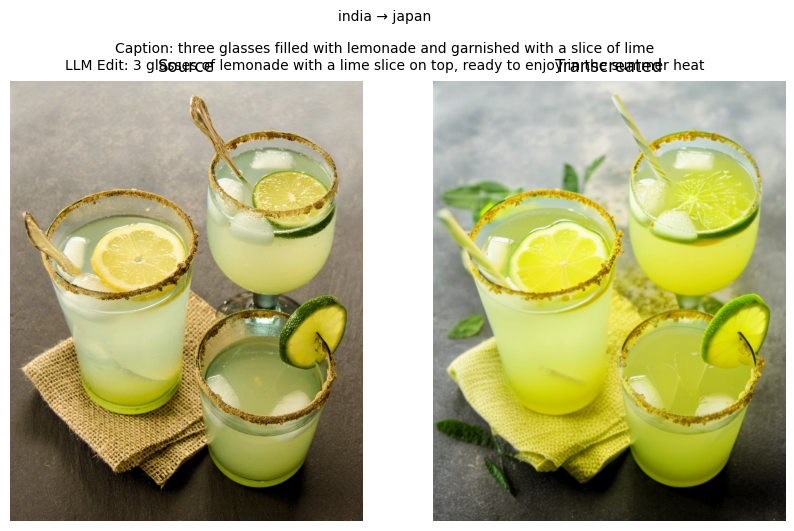

In [ ]:
# Sanity check
show_pair_with_text(df.iloc[100])
